In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from docs.untitled import fred_api_key
import pandas as pd
import fredapi as fr
from sklearn.preprocessing import MinMaxScaler
import numpy as np


fred = fr.Fred(fred_api_key)




device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

"""Interest Rates(Fed Funds Rate) """

ffr = fred.get_series("FEDFUNDS")
ffr.name = "Fed Funds Rate"

data = pd.DataFrame(ffr).dropna()

data = data.reset_index()
data['Date'] = data['index']
data.drop("index",axis=1,inplace=True)
data.head(10)

cuda:0


,Fed Funds Rate,Date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01
5,1.28,1954-12-01
6,1.39,1955-01-01
7,1.29,1955-02-01
8,1.35,1955-03-01
9,1.43,1955-04-01


In [8]:

training = data.iloc[:,0:1].values



train_split = int(len(training) * .70)

train_data = training[:train_split]
test_data = training[train_split:]
train_data.shape
test_data.shape

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

def slider(df, seq_length):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X_ = df[i:(i + seq_length)]
        y_ = df[i + seq_length]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

seq_length = 5
X_train, y_train = slider(train_data, seq_length)
X_test,y_test = slider(test_data,seq_length)


X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


X_train.shape
y_train.shape


class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        c0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

C:\Users\katsa\AppData\Local\Temp\ipykernel_11780\3348398669.py:77: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_11780\3348398669.py:79: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.2721; Test RSME: 0.105
Epoch: 1; train_RSEM: 0.1872; Test RSME: 0.1773
Epoch: 2; train_RSEM: 0.201; Test RSME: 0.3311
Epoch: 3; train_RSEM: 0.2025; Test RSME: 0.3329
Epoch: 4; train_RSEM: 0.1668; Test RSME: 0.2577
Epoch: 5; train_RSEM: 0.1652; Test RSME: 0.1904
Epoch: 6; train_RSEM: 0.1776; Test RSME: 0.1534
Epoch: 7; train_RSEM: 0.1792; Test RSME: 0.1419
Epoch: 8; train_RSEM: 0.1676; Test RSME: 0.1476
Epoch: 9; train_RSEM: 0.1492; Test RSME: 0.168
Epoch: 10; train_RSEM: 0.1376; Test RSME: 0.2002
Epoch: 11; train_RSEM: 0.1442; Test RSME: 0.2326
Epoch: 12; train_RSEM: 0.1492; Test RSME: 0.2403
Epoch: 13; train_RSEM: 0.1335; Test RSME: 0.2141
Epoch: 14; train_RSEM: 0.1162; Test RSME: 0.1717
Epoch: 15; train_RSEM: 0.1147; Test RSME: 0.1327
Epoch: 16; train_RSEM: 0.1183; Test RSME: 0.1069
Epoch: 17; train_RSEM: 0.1114; Test RSME: 0.09528
Epoch: 18; train_RSEM: 0.09157; Test RSME: 0.09635
Epoch: 19; train_RSEM: 0.07822; Test RSME: 0.1079
Epoch: 20; train_RSEM: 0.0908

In [9]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = data.iloc[train_split + seq_length:]['Date'].reset_index(drop=True)


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Interest Rate": actual_rescaled.flatten(),
    "Predicted Interest Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

         Date  Actual Interest Rate  Predicted Interest Rate
0  2004-07-01                  1.26                 1.068696
1  2004-08-01                  1.43                 1.250661
2  2004-09-01                  1.61                 1.480882
3  2004-10-01                  1.76                 1.691145
4  2004-11-01                  1.93                 1.854098
5  2004-12-01                  2.16                 2.009102
6  2005-01-01                  2.28                 2.222731
7  2005-02-01                  2.50                 2.381438
8  2005-03-01                  2.63                 2.568926
9  2005-04-01                  2.79                 2.721629
10 2005-05-01                  3.00                 2.867101
11 2005-06-01                  3.04                 3.063556
12 2005-07-01                  3.26                 3.145798
13 2005-08-01                  3.50                 3.306505
14 2005-09-01                  3.62                 3.557008
15 2005-10-01           

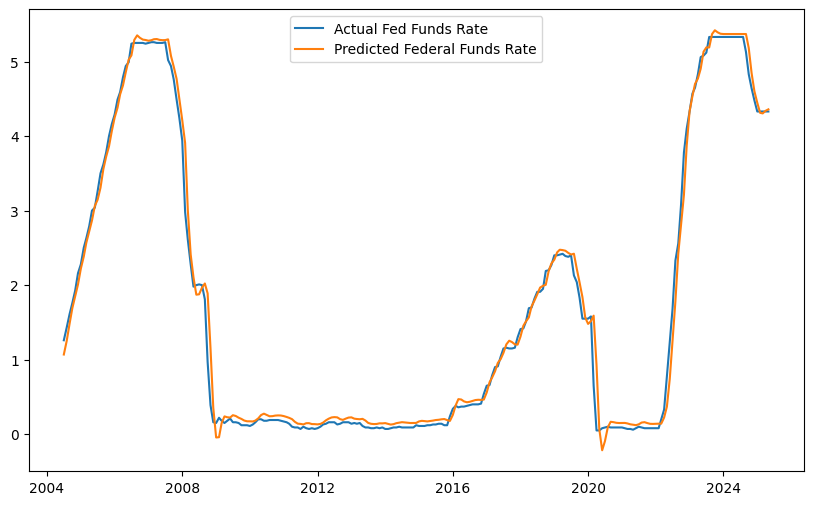

In [10]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Interest Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Interest Rate'],label="Predicted Federal Funds Rate")
plt.legend()
plt.savefig("images/predicted_actual_interestrates.png")
plt.show()
